## Temporary Oyster dashboard ##

Pulling in data from Humboldt Bay Shore station to make a temporary oysterdashboard display.

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
from dateutil import tz

import seaborn as sns
import numpy as np
import airsea
from astral import sun, Observer

__Humboldt Bay ERDDAP request__

The most recent 7 day worth of data are pulled from the CeNCOOS ERDDAP. Data are converted to pacific time from UTC

In [116]:
url = "http://erddap.cencoos.org/erddap/tabledap/edu_humboldt_humboldt.csvp?time%2Cmass_concentration_of_chlorophyll_in_sea_water%2Cmass_concentration_of_oxygen_in_sea_water%2Cfractional_saturation_of_oxygen_in_sea_water%2Csea_water_practical_salinity%2Csea_water_temperature%2Csea_water_turbidity%2Csea_water_ph_reported_on_total_scale&time>now-7days"
headers= ['time','chlorophyll','oxygen_conc','oxygen_frac','salinity','swtemp','turbidity','pH']
df = pd.read_csv(url, names=headers,skiprows=1)
df['dateTime'] = pd.to_datetime(df['time'])
df.index = df['dateTime']
df = df.tz_convert('US/Pacific')
df_hourly = df.resample('30T').mean()
df_rolling = df[["chlorophyll","oxygen_conc","oxygen_frac","salinity","swtemp","turbidity","pH"]].rolling(window=4*6,center=True,win_type='boxcar').mean()
df_hourly.tail()

,chlorophyll,oxygen_conc,oxygen_frac,salinity,swtemp,turbidity,pH
dateTime,,,,,,,
2021-01-15 11:00:00-08:00,1.05,8.705,97.55,31.975,11.405,7.2,8.035
2021-01-15 11:30:00-08:00,1.25,8.715,97.65,31.965,11.415,6.2,8.030
2021-01-15 12:00:00-08:00,1.15,8.755,97.95,31.830,11.405,6.0,8.035
2021-01-15 12:30:00-08:00,1.10,8.715,97.45,31.730,11.395,5.4,8.010
2021-01-15 13:00:00-08:00,0.90,8.720,97.50,31.620,11.390,4.9,8.020


__Offshore Wind Data__

Offshore wind and temperature data are pulled for the past 7 days from NDBC 46022 EEL Buoy.
Data Processing:
    - Dates are converted to Pacific time
    - Windstress is calculated
    - Windstress is converted to a vector (U,V)
    - Ekman Transport is calculated from alongshore windstress

In [117]:
url = 'http://erddap.cencoos.org/erddap/tabledap/wmo_46022.csvp?time%2Csea_water_temperature%2Cwind_speed%2Cwind_from_direction&time>now-7days'
headers= ['time','wtemp_offshore','wind_speed_ms','wind_from_direction']
wind_df = pd.read_csv(url,names=headers,skiprows=1)
wind_df['dateTime'] = pd.to_datetime(wind_df['time'])
wind_df.index = wind_df['dateTime']
wind_df = wind_df.tz_convert('US/Pacific')
wind_df.resample('1h').nearest()

,time,wtemp_offshore,wind_speed_ms,wind_from_direction,dateTime
dateTime,,,,,
2021-01-08 13:00:00-08:00,2021-01-08T21:40:00Z,11.6,4.0,350.0,2021-01-08 21:40:00+00:00
2021-01-08 14:00:00-08:00,2021-01-08T22:00:00Z,11.6,3.0,350.0,2021-01-08 22:00:00+00:00
2021-01-08 15:00:00-08:00,2021-01-08T23:00:00Z,11.6,4.0,360.0,2021-01-08 23:00:00+00:00
2021-01-08 16:00:00-08:00,2021-01-09T00:00:00Z,11.6,6.0,10.0,2021-01-09 00:00:00+00:00
2021-01-08 17:00:00-08:00,2021-01-09T01:00:00Z,11.6,6.0,20.0,2021-01-09 01:00:00+00:00
...,...,...,...,...,...
2021-01-15 08:00:00-08:00,2021-01-15T16:00:00Z,11.7,1.0,80.0,2021-01-15 16:00:00+00:00
2021-01-15 09:00:00-08:00,2021-01-15T17:00:00Z,11.7,3.0,330.0,2021-01-15 17:00:00+00:00
2021-01-15 10:00:00-08:00,2021-01-15T18:00:00Z,11.8,2.0,340.0,2021-01-15 18:00:00+00:00


In [118]:
wind_df['windstress'] = airsea.windstress.stress(wind_df['wind_speed_ms'],z=3.8, drag='largepond')

In [119]:
v = wind_df['windstress'] * -np.cos(np.deg2rad(wind_df['wind_from_direction']))
u = wind_df['windstress'] * -np.sin(np.deg2rad(wind_df['wind_from_direction']))
ekman = (-1/0.935)*v
print(ekman)

dateTime
2021-01-15 12:20:00-08:00    0.024674
2021-01-15 12:00:00-08:00    0.024674
2021-01-15 11:40:00-08:00    0.028491
2021-01-15 11:30:00-08:00    0.028058
2021-01-15 11:20:00-08:00    0.026773
                               ...   
2021-01-08 15:00:00-08:00    0.028491
2021-01-08 14:40:00-08:00    0.028491
2021-01-08 14:20:00-08:00    0.028491
2021-01-08 14:00:00-08:00    0.015783
2021-01-08 13:40:00-08:00    0.028058
Length: 949, dtype: float64


__Get Sunrise and Sunset times__

Using the `astral` api package we can request sunrise and sunset times for humboldt to use for shading the plots.

In [120]:
days = 7
stime = df['dateTime'].max()
etime = stime - dt.timedelta(days=days)
obs = Observer(latitude=40.831999, longitude=-124.202152,elevation=0)
sunrise = []
sunset = []
for day in range(days+1):
    sunrise.append(sun.sun(obs,date=stime - dt.timedelta(days=day),tzinfo='US/Pacific')['sunrise'])
    sunset.append(sun.sun(obs,date=stime - dt.timedelta(days=day),tzinfo='US/Pacific')['sunset'])

In [121]:
def add_nighttime(ax,sunrise,sunset):
    ax.axvspan(stime, etime, color='.85',zorder=-5)
    for sr,ss in zip(sunrise,sunset):
        ax.axvspan(ss.astimezone(tz=None),sr.astimezone(tz=None), color='w',zorder=-2)
    return ax

Text(0, -0.3, 'Updated on: 2021-01-15 14:16:42.377399')

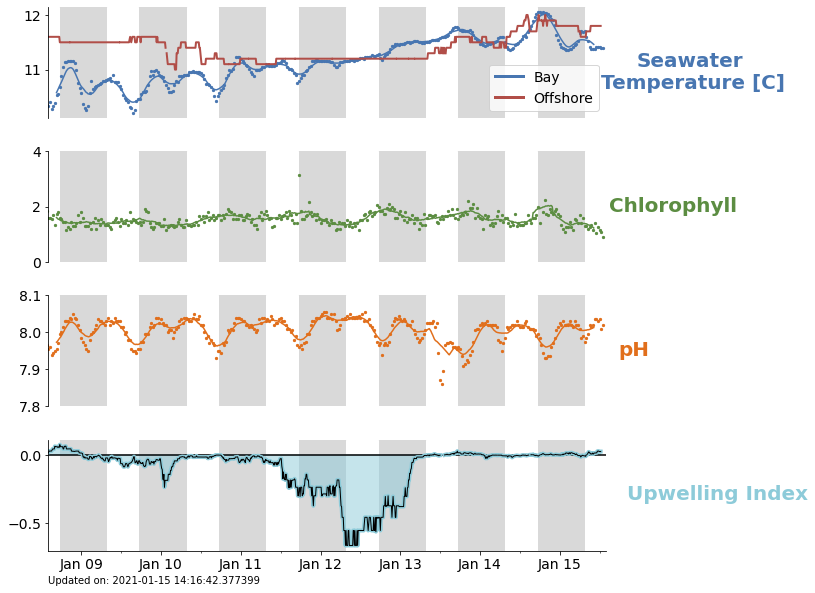

In [220]:
stime = df.index.max() + dt.timedelta(hours=1)
etime = stime - dt.timedelta(days=7)

fig, (ax_temp,ax_chl,ax_ph,ax_wind) = plt.subplots(4,sharex=True,gridspec_kw=dict(hspace=0.3))
fig.set_size_inches(10,10)

ax_temp = add_nighttime(ax_temp,sunrise,sunset)
ax_temp.scatter(df_hourly.index,df_hourly['swtemp'],s=5,c='#4876B1')
ax_temp.plot(df_rolling.index,df_rolling['swtemp'],color='#4876B1',label='Bay')
ax_temp.plot(wind_df.index, wind_df['wtemp_offshore'],color='#B14E48',lw=2,label='Offshore')


ax_temp.get_xaxis().set_visible(False)
sns.despine(ax=ax_temp,bottom=True,trim=False);
ax_temp.yaxis.set_label_position("right")
ax_temp.yaxis.set_label_coords(1.15,.6)

# ax_temp.set_yticks([10,11,12])
ax_temp.set_ylabel('Seawater\n Temperature [C]',rotation=0,labelpad=90,size=20,color='#4876B1',fontweight='bold')
ax_temp.tick_params(axis='y', labelsize=14)
leg = ax_temp.legend(frameon=True,loc='best',fontsize=14)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)




ax_chl = add_nighttime(ax_chl,sunrise,sunset)
ax_chl.scatter(df_hourly.index,df_hourly['chlorophyll'],s=5,c='#5C8D42')
ax_chl.plot(df_rolling.index,df_rolling['chlorophyll'], color='#5C8D42')
ax_chl.set_ylim(0,4)
ax_chl.get_xaxis().set_visible(False)
ax_chl.set_ylabel('Chlorophyll',rotation=0,labelpad=90,size=20,color='#5C8D42',fontweight='bold')
sns.despine(ax=ax_chl,offset=0,bottom=True,trim=False);
ax_chl.tick_params(axis='y', labelsize=14 )
ax_chl.yaxis.set_label_coords(1.12,.42)




ax_ph = add_nighttime(ax_ph,sunrise,sunset)
ax_ph.scatter(df_hourly.index,df_hourly['pH'],s=5,c='#E16F1C')
ax_ph.plot(df_rolling.index,df_rolling['pH'], color='#E16F1C')
ax_ph.set_ylim(7.8,8.1)
ax_ph.get_xaxis().set_visible(False)
ax_ph.set_ylabel('pH',rotation=0,labelpad=90,size=20,color='#E16F1C',fontweight='bold')
sns.despine(ax=ax_ph,offset=0,bottom=True,trim=True);
ax_ph.tick_params(axis='y', labelsize=14)
ax_ph.yaxis.set_label_coords(1.05,.42)



ax_wind = add_nighttime(ax_wind,sunrise,sunset)
ax_wind.plot(ekman.index,ekman,color='#8DCBD9',lw=4)
ax_wind.plot(ekman.index,ekman,color='k',lw=1)
ax_wind.fill_between(ekman.index,ekman,0,color='#8DCBD9',alpha=.5)
ax_wind.hlines(0,stime,etime,color='k',zorder=1)
ax_wind.set_ylabel('Upwelling Index',rotation=0,labelpad=90,size=20,color='#8DCBD9',fontweight='bold')
ax_wind.yaxis.set_label_coords(1.2,.42)

date_fmt = mdates.DateFormatter('%b %d')
sns.despine(ax=ax_wind,offset=0,trim=False);
ax_wind.xaxis.set_major_formatter(date_fmt)
ax_wind.xaxis.set_minor_locator(mdates.HourLocator(12,tz=tz.gettz('US/Pacific')))
ax_wind.tick_params(axis='both', labelsize=14)

ax_wind.set_xlim(etime,stime)
ax_wind.text(0,-.3,'Updated on: {}'.format(dt.datetime.now()),transform=ax_wind.transAxes)
# plt.savefig('humboldt_bay_conditions.png',dpi=300,bbox_inches='tight', pad_inches=0.1,)

In [198]:
def copy_file_to_webserver(FILE):
    """Copy images from to webserver where they can be viewed publically."""
    try:
        os.system('scp -i /etc/ssh/keys/pdaniel/scp_rsa {} skyrocket8.mbari.org:/var/www/html/data/strat-plots/ '.format(FILE))
    except:
        pass

copy_file_to_webserver("humboldt_bay_conditions.png")

datetime.datetime(2021, 1, 15, 13, 56, 35, 965077)